In [20]:
import xgboost
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE, RFECV
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, f1_score
from sklearn.pipeline import Pipeline
from scipy.stats import boxcox
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBRegressor, XGBClassifier, Booster
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK, space_eval
from hyperopt.pyll import scope
import warnings as warnings
from sklearn.exceptions import ConvergenceWarning

In [21]:
robust_scaled = pd.read_parquet('combined_robust.parquet.gzip')
standard_scaled = pd.read_parquet('combined_standard.parquet.gzip')
X_robust = robust_scaled.drop(columns=['is_canceled', 'reservation_status'])
X_standard = standard_scaled.drop(columns=['is_canceled', 'reservation_status'])
y = robust_scaled.is_canceled

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_standard, y, test_size=0.33, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((79991, 29), (79991,), (39399, 29), (39399,))

In [23]:
from sklearn.utils._testing import ignore_warnings
# define pipeline for feature selection
pipeline = Pipeline([
    ('feature_selection', RFE(estimator=RandomForestClassifier())),
    ('model', RandomForestClassifier())
])
# Define the search space for hyperparameters
space = {
    'feature_selection__n_features_to_select': hp.choice('n_features_to_select', range(8, 29)),

    'feature_selection__estimator__n_estimators': hp.choice('n_estimators', range(100, 1000)),
    'feature_selection__estimator__max_depth': hp.choice('max_depth', range(1, 20)),
    'feature_selection__estimator__min_samples_split': hp.choice('min_samples_split', range(2, 10)),
    'feature_selection__estimator__min_samples_leaf': hp.choice('min_samples_leaf', range(1, 10)),
    'feature_selection__estimator__ccp_alpha': hp.quniform('ccp_alpha', 0, 0.1, 0.01),
    'feature_selection__estimator__criterion': hp.choice('criterion',['gini', 'entropy', 'log_loss']),
    'feature_selection__estimator__random_state': 2407,
    'feature_selection__estimator__n_jobs': -1,



}

# Define the objective function for hyperopt
@ignore_warnings(category=ConvergenceWarning)
def objective(params):
    pipeline.set_params(**params)
    pipeline.fit(X_train, y_train)
    preds = pipeline.predict(X_test)
    score = f1_score(y_true=y_test, y_pred=preds)
    print(f'Score: {-score}')
    return {'loss': -score, 'status': STATUS_OK, 'model': pipeline}

trials = Trials()
best = fmin(objective,
            space,
            algo=tpe.suggest,
            max_evals=30,
            trials=trials)
print(best)

Score: -0.7519281168101835                            
Score: -0.6756002672220693                                                       
Score: -0.6881481187174698                                                       
Score: -0.7028470449636756                                                       
Score: -0.7647766581440819                                                       
Score: -0.6821527502967947                                                       
Score: -0.6817230623445335                                                          
Score: -0.6871127147227234                                                          
Score: -0.7076614458760898                                                          
Score: -0.7477932855526216                                                          
Score: -0.689671324849715                                                           
Score: -0.737783258825343                                                          
Score: -0.7510545344983429

In [24]:
#Create instance of best model.
best_model = trials.results[np.argmin([r['loss'] for r in
                                       trials.results])]['model']

#Examine model hyperparameters
print(best_model)

LogisticRegression(C=952.5047715531579, l1_ratio=1.0, max_iter=200, n_jobs=-1,
                   penalty='elasticnet', solver='saga')


In [77]:
pipeline2 = Pipeline([
    ('feature_selection', RFE(estimator=RandomForestClassifier(n_jobs=-1), n_features_to_select=10)),
    ('model', RandomForestClassifier(n_jobs=-1))
])
pipeline2.fit(X_train.drop(['country', 'company', 'agent'], axis=1), y_train)

Pipeline(steps=[('feature_selection',
                 RFE(estimator=RandomForestClassifier(n_jobs=-1),
                     n_features_to_select=10)),
                ('model', RandomForestClassifier(n_jobs=-1))])

In [80]:
pipeline2.score(X_test.drop(['country', 'company', 'agent'], axis=1), y_test)

0.7758064925505723

In [ ]:
pipeline2[:-1].get_feature_names_out()

In [57]:
best_model.n_features_in_

27

In [51]:
best_feature_list = pipeline['feature_selection'].get_feature_names_out()

array(['lead_time', 'arrival_date_week_number', 'stays_in_week_nights',
       'adults', 'babies', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes',
       'days_in_waiting_list', 'adr', 'required_car_parking_spaces',
       'total_of_special_requests', 'is_repeated_guest',
       'total_nights_stayed', 'days_to_status_change', 'total_guests',
       'hotel', 'country', 'market_segment', 'distribution_channel',
       'agent', 'company', 'customer_type', 'meal', 'reserved_room_type',
       'assigned_room_type', 'deposit_type'], dtype=object)

In [28]:
standard_data_reduced = standard_scaled[best_feature_list]
robust_data_reduced = robust_scaled[best_feature_list]

In [48]:
import xgboost as xgb
import joblib
original_booster = xgb.XGBClassifier()
original_booster.load_model('xgb_standard_classifier.json')

In [88]:
params_list = original_booster.get_params()
del params_list['feature_types']
del original_booster.feature_types

AttributeError: 'XGBModel' object has no attribute 'feature_types'

AttributeError: 'XGBModel' object has no attribute 'feature_types'

AttributeError: 'XGBModel' object has no attribute 'feature_types'

In [42]:
X_train_std_red, X_test_std_red  = train_test_split(standard_data_reduced, test_size=0.33)

In [87]:
original_booster.fit(X_train_std_red, np.ravel(y_train),
                     eval_set=[(X_train_std_red, y_train), (X_test_std_red, np.ravel(y_test))])

XGBoostError: [08:16:18] C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/data/data.cc:592: Check failed: size == this->num_col_ (29 vs. 27) : Length of feature_type must be equal to number of columns.

In [81]:
reduced_preds = original_booster.predict(X_test_std_red)
print(classification_report(y_test, reduced_preds))

ValueError: Feature shape mismatch, expected: 29, got 27

In [ ]:
import logging
logging.log()

In [94]:
# Do a recursive feature elimination with rf then optimize it

def objective_rfe(params):
    rfe_params = params['rfe']
    random_forest_params = params['random_forest']
    clf = RandomForestClassifier(**random_forest_params)
    rfe = RFECV(clf, cv = 5, scoring='f1', step = 1, min_features_to_select=rfe_params['min_features'], n_jobs=-1, verbose=True)
    X = standard_scaled.drop(['is_canceled', 'reservation_status'], axis=1).copy()
    y = standard_scaled.is_canceled.copy()
    rfe.fit(X,y)
    X_reduced = rfe.transform(X)
    score = np.mean(cross_val_score(clf, X_reduced, y, cv=5, scoring='f1'))

    return {'loss': -score, 'status': STATUS_OK, 'min_features': rfe_params['min_features'], 'model': clf, 'rfe': rfe}


rfe_space = {
    'random_forest': {
        'n_estimators': hp.choice('n_estimators', range(100, 1000)),
        'max_depth': hp.choice('max_depth', range(1, 20)),
        'min_samples_split': hp.choice('min_samples_split', range(2, 10)),
        'min_samples_leaf': hp.choice('min_samples_leaf', range(1, 10)),
        'ccp_alpha': hp.quniform('ccp_alpha', 0, 0.1, 0.01),
        'criterion': hp.choice('criterion',['gini', 'entropy', 'log_loss']),
        'random_state': 2407,
        'n_jobs': -1,
        'verbose': True
    },
    'rfe':{
        'min_features': hp.choice('min_features', range(1, 30))
    }
}

In [ ]:
trials = Trials()
best = fmin(objective_rfe,
            rfe_space,
            algo=tpe.suggest,
            max_evals=30,
            trials=trials)

print('Best Hyperparameters:', best)
print('Best Score:', -trials.best_trial['result']['loss'])

Fitting estimator with 29 features.                   
  0%|          | 0/30 [02:05<?, ?trial/s, best loss=?]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.7s



Fitting estimator with 28 features.                   
  0%|          | 0/30 [02:08<?, ?trial/s, best loss=?]

[Parallel(n_jobs=-1)]: Done 104 out of 104 | elapsed:    2.8s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.7s



Fitting estimator with 27 features.                   
  0%|          | 0/30 [02:12<?, ?trial/s, best loss=?]

[Parallel(n_jobs=-1)]: Done 104 out of 104 | elapsed:    3.0s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.8s



Fitting estimator with 26 features.                   
  0%|          | 0/30 [02:15<?, ?trial/s, best loss=?]

[Parallel(n_jobs=-1)]: Done 104 out of 104 | elapsed:    3.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.8s



Fitting estimator with 25 features.                   
  0%|          | 0/30 [02:18<?, ?trial/s, best loss=?]

[Parallel(n_jobs=-1)]: Done 104 out of 104 | elapsed:    2.9s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.7s



Fitting estimator with 24 features.                   
  0%|          | 0/30 [02:21<?, ?trial/s, best loss=?]

[Parallel(n_jobs=-1)]: Done 104 out of 104 | elapsed:    3.0s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.6s

[Parallel(n_jobs=-1)]: Done 104 out of 104 | elapsed:    2.6s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.7s

[Parallel(n_jobs=-1)]: Done 104 out of 104 | elapsed:    2.8s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.6s

[Parallel(n_jobs=-1)]: Done 104 out of 104 | elapsed:    2.5s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.1s

[Parallel(n_jobs=-1)]: Done 104 out of 104 | elapsed:    3.3s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16

  3%|▎         | 1/30 [02:42<1:18:46, 162.98s/trial, best loss: -0.45857924824220414]

[Parallel(n_jobs=-1)]: Done 104 out of 104 | elapsed:    2.0s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 104 out of 104 | elapsed:    0.0s finished



  3%|▎         | 1/30 [46:39<22:33:03, 2799.44s/trial, best loss: -0.45857924824220414]

In [ ]:
best

In [5]:
import pandas as pd
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.model_selection import train_test_split

robust_scaled = pd.read_parquet('combined_robust.parquet.gzip')
standard_scaled = pd.read_parquet('combined_standard.parquet.gzip')
X_robust = robust_scaled.drop(columns=['is_canceled', 'reservation_status'])
X_standard = standard_scaled.drop(columns=['is_canceled', 'reservation_status'])
y = robust_scaled.is_canceled

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_standard, y, test_size=0.33, random_state=42)

# Initialize the OMP model with the desired number of features
n_features_to_select = 12
omp = OrthogonalMatchingPursuit(n_nonzero_coefs=n_features_to_select)

# Fit the model on the training data
omp.fit(X_train, y_train)

# Transform the data to only include the selected features
X_train_omp = X_train[omp.fe()]
X_test_omp = X_test[omp.get_params()]

# Train a model on the selected features
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_omp, y_train)

# Evaluate the model on the test set
score = rf.score(X_test_omp, y_test)
print(f"R^2 score using OMP-selected features: {score:.3f}")

C:\Users\fight\AppData\Local\Temp\ipykernel_72856\870573886.py:22: FutureWarning: Passing a dict as an indexer is deprecated and will raise in a future version. Use a list instead.
  X_train_omp = X_train[omp.get_params()]


KeyError: "None of [Index(['fit_intercept', 'n_nonzero_coefs', 'normalize', 'precompute', 'tol'], dtype='object')] are in the [columns]"

C:\Users\fight\Documents\Anaconda3\envs\workspace2\lib\site-packages\sklearn\linear_model\_omp.py:771: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  coef_, self.n_iter_ = orthogonal_mp_gram(


OrthogonalMatchingPursuit(n_nonzero_coefs=29)

In [40]:
corr_matrix = X_standard.corr().abs()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
corr_matrix = corr_matrix.mask(mask)
# find the indices of the features with correlation greater than a threshold
threshold = 0.8
to_drop = []
for column in corr_matrix.columns:
    if any(corr_matrix[column] > threshold):
        to_drop.append(column)

# drop the highly correlated features
X_standard_reduced = X_standard.drop(to_drop, axis=1)

# print the remaining features
print(X_standard_reduced.columns)

Index(['lead_time', 'arrival_date_week_number', 'stays_in_weekend_nights',
       'children', 'babies', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes',
       'days_in_waiting_list', 'adr', 'required_car_parking_spaces',
       'total_of_special_requests', 'is_repeated_guest', 'total_nights_stayed',
       'days_to_status_change', 'total_guests', 'country', 'market_segment',
       'distribution_channel', 'agent', 'assigned_room_type', 'deposit_type'],
      dtype='object')


In [62]:
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(X_standard_reduced, y, test_size=0.33, random_state=42)
omp = OrthogonalMatchingPursuit(n_nonzero_coefs=X_standard_reduced.shape[1], fit_intercept=True)
omp.fit(X_train, y_train)

C:\Users\fight\Documents\Anaconda3\envs\workspace2\lib\site-packages\sklearn\linear_model\_omp.py:771: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  coef_, self.n_iter_ = orthogonal_mp_gram(


OrthogonalMatchingPursuit(n_nonzero_coefs=22)

In [64]:
feature_coef_list = []
for i in range(len(omp.coef_)):
    feature_coef_list.append([omp.feature_names_in_[i], omp.coef_[i]])
feature_coefs = pd.DataFrame(feature_coef_list, columns=['features', 'coefficient'])
feature_coefs

,features,coefficient
0,lead_time,0.074378
1,arrival_date_week_number,-0.009364
2,stays_in_weekend_nights,0.002245
3,children,-0.003147
4,babies,-0.002701
5,previous_cancellations,0.020663
6,previous_bookings_not_canceled,-0.009802
7,booking_changes,-0.048267
8,days_in_waiting_list,-0.004639
9,adr,0.029959


In [67]:
X_standard_reduced.columns

Index(['lead_time', 'arrival_date_week_number', 'stays_in_weekend_nights',
       'children', 'babies', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes',
       'days_in_waiting_list', 'adr', 'required_car_parking_spaces',
       'total_of_special_requests', 'is_repeated_guest', 'total_nights_stayed',
       'days_to_status_change', 'total_guests', 'country', 'market_segment',
       'distribution_channel', 'agent', 'assigned_room_type', 'deposit_type'],
      dtype='object')

In [69]:
X_standard_reduced2 = X_standard_reduced.drop(['country', 'agent'], axis=1)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_standard_reduced2, y, test_size=0.33, random_state=42)
omp2 = OrthogonalMatchingPursuit(n_nonzero_coefs=X_standard_reduced2.shape[1], fit_intercept=True)
omp2.fit(X_train2, y_train2)
feature_coef_list2 = []
for i in range(len(omp2.coef_)):
    feature_coef_list2.append([omp2.feature_names_in_[i], omp2.coef_[i]])
feature_coefs2 = pd.DataFrame(feature_coef_list2, columns=['features', 'coefficient'])
feature_coefs2

C:\Users\fight\Documents\Anaconda3\envs\workspace2\lib\site-packages\sklearn\linear_model\_omp.py:771: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  coef_, self.n_iter_ = orthogonal_mp_gram(


,features,coefficient
0,lead_time,0.074238
1,arrival_date_week_number,-0.009937
2,stays_in_weekend_nights,0.001347
3,children,0.001670
4,babies,-0.002998
5,previous_cancellations,0.025539
6,previous_bookings_not_canceled,-0.008332
7,booking_changes,-0.046232
8,days_in_waiting_list,-0.009045
9,adr,0.042873


In [70]:
omp_features_pos = feature_coefs[feature_coefs['coefficient'] > 0]
omp_features_abs = feature_coefs[feature_coefs['coefficient'] != 0]
omp2_features_pos = feature_coefs2[feature_coefs2['coefficient'] > 0]
omp2_features_abs = feature_coefs2[feature_coefs2['coefficient'] != 0]

In [84]:
X_1 = X_standard[omp_features_pos['features']]
X_2 = X_standard[omp_features_abs['features']]
X_3 = X_standard[omp2_features_pos['features']]
X_4 = X_standard[omp2_features_pos['features']]

In [163]:
from sklearn.metrics import confusion_matrix, roc_auc_score, auc, f1_score, fbeta_score, mean_squared_error
def classification_report_with_scores(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    fpr = fp / (fp + tn)
    fnr = fn / (fn + tp)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    f1 = f1_score(y_true, y_pred)
    f2 = fbeta_score(y_true, y_pred, beta=2)
    AUC = roc_auc_score(y_true, y_pred)
    cls_report = classification_report(y_true, y_pred)

    # Append additional metrics to classification report
    cls_report = f'\nAccuracy: {accuracy:.3f}' \
                 f'\nFalse Positive Rate: {fpr:.3f}' \
                 f'\nFalse Negative Rate: {fnr:.3f}' \
                 f'\nPrecision: {precision:.3f}' \
                 f'\nRecall: {recall:.3f}' \
                 f'\nRMSE:{rmse:.3f}' \
                 f'\nF1-Score:{f1:.3f}' \
                 f'\nF2-Score:{f2:.3f}' \
                 f'\nROC_AUC_Score:{AUC:.3f}' + \
                 f'\n{cls_report}'

    return cls_report

In [93]:
from typing import Any
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc_params = {'max_depth': 23,
                'max_features': 2,
                'min_samples_leaf': 0.135540739226335,
                'min_samples_split': 0.5204337092518656,
                'n_estimators': 80}
def multi_checker(args):
    for i in range(len(args)):
        X_train, X_test, y_train, y_test = train_test_split(args[i], y, test_size=0.33)
        rfc.set_params(**rfc_params, n_jobs=-1)
        rfc.fit(X_train, np.ravel(y_train))
        preds = rfc.predict(X_test)
        print(classification_report_with_scores(np.ravel(y_test), np.ravel(preds)))

In [94]:
multi_checker([X_1, X_2, X_3, X_4])


Accuracy: 0.677
False Positive Rate: 0.041
False Negative Rate: 0.798
Precision: 0.745
Recall: 0.202
RMSE:0.568
F1-Score:0.318
F2-Score:0.237
ROC_AUC_Score:0.581              precision    recall  f1-score   support

           0       0.67      0.96      0.79     24732
           1       0.75      0.20      0.32     14667

    accuracy                           0.68     39399
   macro avg       0.71      0.58      0.55     39399
weighted avg       0.70      0.68      0.61     39399



C:\Users\fight\AppData\Local\Temp\ipykernel_72856\402414238.py:7: RuntimeWarning: invalid value encountered in longlong_scalars
  precision = tp / (tp + fp)
C:\Users\fight\Documents\Anaconda3\envs\workspace2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fight\Documents\Anaconda3\envs\workspace2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fight\Documents\Anaconda3\envs\workspace2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are i


Accuracy: 0.630
False Positive Rate: 0.000
False Negative Rate: 1.000
Precision: nan
Recall: 0.000
RMSE:0.608
F1-Score:0.000
F2-Score:0.000
ROC_AUC_Score:0.500              precision    recall  f1-score   support

           0       0.63      1.00      0.77     24829
           1       0.00      0.00      0.00     14570

    accuracy                           0.63     39399
   macro avg       0.32      0.50      0.39     39399
weighted avg       0.40      0.63      0.49     39399



C:\Users\fight\AppData\Local\Temp\ipykernel_72856\402414238.py:7: RuntimeWarning: invalid value encountered in longlong_scalars
  precision = tp / (tp + fp)
C:\Users\fight\Documents\Anaconda3\envs\workspace2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fight\Documents\Anaconda3\envs\workspace2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fight\Documents\Anaconda3\envs\workspace2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are i


Accuracy: 0.631
False Positive Rate: 0.000
False Negative Rate: 1.000
Precision: nan
Recall: 0.000
RMSE:0.608
F1-Score:0.000
F2-Score:0.000
ROC_AUC_Score:0.500              precision    recall  f1-score   support

           0       0.63      1.00      0.77     24853
           1       0.00      0.00      0.00     14546

    accuracy                           0.63     39399
   macro avg       0.32      0.50      0.39     39399
weighted avg       0.40      0.63      0.49     39399


Accuracy: 0.631
False Positive Rate: 0.000
False Negative Rate: 1.000
Precision: nan
Recall: 0.000
RMSE:0.607
F1-Score:0.000
F2-Score:0.000
ROC_AUC_Score:0.500              precision    recall  f1-score   support

           0       0.63      1.00      0.77     24864
           1       0.00      0.00      0.00     14535

    accuracy                           0.63     39399
   macro avg       0.32      0.50      0.39     39399
weighted avg       0.40      0.63      0.49     39399



C:\Users\fight\AppData\Local\Temp\ipykernel_72856\402414238.py:7: RuntimeWarning: invalid value encountered in longlong_scalars
  precision = tp / (tp + fp)
C:\Users\fight\Documents\Anaconda3\envs\workspace2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fight\Documents\Anaconda3\envs\workspace2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fight\Documents\Anaconda3\envs\workspace2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are i

In [59]:
omp.get_params()

{'fit_intercept': True,
 'n_nonzero_coefs': 22,
 'normalize': 'deprecated',
 'precompute': 'auto',
 'tol': 2}

In [45]:
omp_preds = omp.predict(X_test)
def sigmoid(x):
    return 1/(1+np.exp(-x))
omp_preds_sigmoid = sigmoid(omp_preds)
omp_preds_binary = np.where(omp_preds_sigmoid>=0.5, 1, 0)

In [46]:
print(classification_report(y_test,omp_preds_binary))

              precision    recall  f1-score   support

           0       0.97      0.08      0.15     24754
           1       0.39      1.00      0.56     14645

    accuracy                           0.42     39399
   macro avg       0.68      0.54      0.35     39399
weighted avg       0.75      0.42      0.30     39399



In [60]:

print(omp.coef_)

[ 0.07437788 -0.0093641   0.00224503 -0.00314658 -0.002701    0.02066284
 -0.00980225 -0.04826705 -0.00463873  0.02995892 -0.07079428 -0.07438299
 -0.0168116   0.02091085  0.          0.02065279  0.0216274  -0.02792132
 -0.09519766  0.15834388 -0.04696958  0.14771123]


In [61]:
print(omp.feature_names_in_)

['lead_time' 'arrival_date_week_number' 'stays_in_weekend_nights'
 'children' 'babies' 'previous_cancellations'
 'previous_bookings_not_canceled' 'booking_changes' 'days_in_waiting_list'
 'adr' 'required_car_parking_spaces' 'total_of_special_requests'
 'is_repeated_guest' 'total_nights_stayed' 'days_to_status_change'
 'total_guests' 'country' 'market_segment' 'distribution_channel' 'agent'
 'assigned_room_type' 'deposit_type']


In [7]:
selected_indices = np.where(omp.coef_ != 0)[0]
X_train_selected = X_train[:, selected_indices]
X_test_selected = X_test[:, selected_indices]
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_jobs=-1)
clf.fit(X_train_selected, y_train)
y_pred = clf.predict(X_test_selected)
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

InvalidIndexError: (slice(None, None, None), array([ 0,  9, 12, 13, 15, 17, 19, 22, 25, 28], dtype=int64))

In [97]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
rfe = RFE(model, n_features_to_select=10)
rfe = rfe.fit(X_standard, y)
print('Ranking of Features:')
print(rfe.ranking_)
print('Selected Features:')
print(X_standard.columns[rfe.support_])

Ranking of Features:
[ 4 11 18 17 16 15 19  1  1  7 12  9  1  3  8 10 20  6  5  1 13 14  1  1
  2  1  1  1  1]
Selected Features:
Index(['previous_cancellations', 'previous_bookings_not_canceled',
       'required_car_parking_spaces', 'country', 'agent', 'company', 'meal',
       'reserved_room_type', 'assigned_room_type', 'deposit_type'],
      dtype='object')


In [101]:
rand_forest = RandomForestClassifier()
rand_forest.set_params(n_jobs=-1)
feature_list = ['previous_cancellations', 'previous_bookings_not_canceled',
                'required_car_parking_spaces', 'country', 'agent', 'company', 'meal',
                'reserved_room_type', 'assigned_room_type', 'deposit_type']
X_train, X_test, y_train, y_test = train_test_split(X_standard, y, test_size=0.33)
X_train_new, X_test_new = X_train[feature_list], X_test[feature_list]
rand_forest.fit(X_train_new, y_train)
print(classification_report_with_scores(y_test, rand_forest.predict(X_test_new)))


Accuracy: 0.913
False Positive Rate: 0.048
False Negative Rate: 0.154
Precision: 0.913
Recall: 0.846
RMSE:0.295
F1-Score:0.878
F2-Score:0.859
ROC_AUC_Score:0.899              precision    recall  f1-score   support

           0       0.91      0.95      0.93     24803
           1       0.91      0.85      0.88     14596

    accuracy                           0.91     39399
   macro avg       0.91      0.90      0.91     39399
weighted avg       0.91      0.91      0.91     39399



In [103]:
model2 = RandomForestClassifier(n_jobs=-1)
rfe2 = RFE(model2, n_features_to_select=10)
rfe2 = rfe2.fit(X_standard.drop(['country', 'company', 'agent'], axis=1), y)


Ranking of Features:
[ 1  1 10  7 11 13 16  4 12  6 14  1  8  3 15  5 17  9  1  1  2  1  1  1
  1  1]
Selected Features:


IndexError: boolean index did not match indexed array along dimension 0; dimension is 29 but corresponding boolean dimension is 26

In [110]:
print('Ranking of Features:')
print(rfe2.ranking_)
print('Selected Features:')
print((X_standard.drop(['country', 'company', 'agent'], axis=1).columns[rfe2.support_]))

Ranking of Features:
[ 1  1 10  7 11 13 16  4 12  6 14  1  8  3 15  5 17  9  1  1  2  1  1  1
  1  1]
Selected Features:
Index(['lead_time', 'arrival_date_week_number', 'adr', 'hotel',
       'market_segment', 'customer_type', 'meal', 'reserved_room_type',
       'assigned_room_type', 'deposit_type'],
      dtype='object')


In [114]:
feature_list2 = ['lead_time', 'arrival_date_week_number', 'adr', 'hotel',
                 'market_segment', 'customer_type', 'meal', 'reserved_room_type',
                 'assigned_room_type', 'deposit_type', 'previous_cancellations', 'previous_bookings_not_canceled']
X_train_new2, X_test_new2 = X_train[feature_list2], X_test[feature_list2]
model2.fit(X_train_new2, y_train)
print(classification_report_with_scores(y_test, model2.predict(X_test_new2)))


Accuracy: 0.785
False Positive Rate: 0.091
False Negative Rate: 0.427
Precision: 0.788
Recall: 0.573
RMSE:0.464
F1-Score:0.664
F2-Score:0.606
ROC_AUC_Score:0.741              precision    recall  f1-score   support

           0       0.78      0.91      0.84     24803
           1       0.79      0.57      0.66     14596

    accuracy                           0.78     39399
   macro avg       0.79      0.74      0.75     39399
weighted avg       0.79      0.78      0.78     39399



In [120]:
from hyperopt import hp, fmin, STATUS_OK, Trials, space_eval, tpe
from hyperopt.pyll import scope
space_rf = {
    'n_estimators': hp.choice('n_estimators', range(100, 1000)),
    'max_depth': hp.choice('max_depth', range(1, 20)),
    'min_samples_split': hp.choice('min_samples_split', range(2, 10)),
    'min_samples_leaf': hp.choice('min_samples_leaf', range(1, 10)),
    'ccp_alpha': hp.quniform('ccp_alpha', 0, 0.1, 0.01),
    'criterion': hp.choice('criterion',['gini', 'entropy', 'log_loss']),
    'random_state': 2407,
    'n_jobs': -1,
    'max_features': 10
}

def objective_rf(params):
    clf = RandomForestClassifier(**params)
    clf.fit(X_train_new2, np.ravel(y_train))
    y_pred = clf.predict(X_test_new2)
    rmse = mean_squared_error(y_true=np.ravel(y_test), y_pred=y_pred, squared=False)
    f1 = f1_score(y_true=np.ravel(y_test), y_pred=y_pred)
    print("Score:", f1)
    return {'loss': -f1, 'status': STATUS_OK}

In [121]:
trials = Trials()
best = fmin(fn=objective_rf,
            space=space_rf,
            algo=tpe.suggest,
            max_evals=30,
            trials=trials)
print(best)

Score:                                                
0.4653304725522006                                    
Score:                                                                           
0.4679296487657221                                                               
Score:                                                                           
0.5272727272727273                                                               
Score:                                                                           
0.525720576461169                                                                
Score:                                                                           
0.4653304725522006                                                               
Score:                                                                           
0.4653304725522006                                                               
Score:                                                                

KeyboardInterrupt: 

In [124]:
unique_list = list(set(feature_list+feature_list2))
X_unique = X_standard[unique_list]
X_unique.columns.__len__()

16

In [184]:
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

def train_rf_classifier(X_train:pd.DataFrame, y_train: pd.DataFrame, clf: RandomForestClassifier):
    logger.debug(msg='Training Start')
    clf.fit(X_train, y_train)
    logger.debug('Training End')
    return clf

space_rf_2 = {
    'n_estimators': hp.choice('n_estimators', range(100, 1000)),
    'max_depth': hp.choice('max_depth', range(1, 20)),
    'min_samples_split': hp.choice('min_samples_split', range(2, 10)),
    'min_samples_leaf': hp.choice('min_samples_leaf', range(1, 10)),
    'criterion': 'log_loss',
    'n_jobs': -1
}

def objective_rf_2(params):
    clf = RandomForestClassifier(**params)
    X_train, X_test, y_train, y_test = train_test_split(X_unique, y, test_size=0.33)
    clf = train_rf_classifier(X_train, y_train, clf)
    preds = clf.predict(X_test)
    f1 = f1_score(np.ravel(y_test), np.ravel(preds))
    print("SCORE:", f1)
    return {'loss': -f1, 'status': STATUS_OK}

In [147]:
trials = Trials()
best2 = fmin(fn=objective_rf_2,
            space=space_rf_2,
            algo=tpe.suggest,
            max_evals=30,
            trials=trials)
print(best2)

SCORE:                                                
0.7970525985733322                                    
SCORE:                                                                           
0.8599969956436834                                                               
SCORE:                                                                           
0.5028647431962349                                                               
SCORE:                                                                           
0.5829025464292552                                                               
SCORE:                                                                           
0.8297510437606308                                                               
SCORE:                                                                           
0.8740031897926634                                                               
SCORE:                                                                

In [258]:
space_rf_3 = {
    'n_estimators': scope.int(hp.uniform('n_estimators', 100, 1000)),
    'max_depth': scope.int(hp.uniform('max_depth', 1, 30)),
    'min_samples_split': scope.int(hp.uniform('min_samples_split', 1, 20)),
    'min_samples_leaf': scope.int(hp.uniform('min_samples_leaf', 1,  20)),
    'criterion': 'gini',
    'n_jobs': -1,
    'max_features': 9
}

def objective_rf_3(params):
    clf = RandomForestClassifier(**params)
    X_train, X_test, y_train, y_test = train_test_split(X_unique, y, test_size=0.33)
    clf = train_rf_classifier(X_train, y_train, clf)
    preds = clf.predict(X_test)
    f1 = f1_score(np.ravel(y_test), np.ravel(preds))
    print("SCORE:", f1)
    return {'loss': -f1, 'status': STATUS_OK, 'model': clf}

In [185]:
trials = Trials()
best3 = fmin(fn=objective_rf_3,
             space=space_rf_3,
             algo=tpe.suggest,
             max_evals=30,
             trials=trials)
print(best3)

SCORE:                                                
0.9099105545617173                                    
SCORE:                                                                           
0.470969427750196                                                                
SCORE:                                                                           
0.8711570914960746                                                               
SCORE:                                                                           
0.9044282411524098                                                               
SCORE:                                                                           
0.9063686357991839                                                               
SCORE:                                                                           
0.7145750627886251                                                               
SCORE:                                                                

In [189]:
best_model_rf_3 = trials.results[np.argmin([r['loss'] for r in
                                            trials.results])]['model']

worst_model_rf_3 = trials.results[np.argmax([r['loss'] for r in
                                            trials.results])]['model']

In [190]:
best_model_rf_3

RandomForestClassifier(max_depth=26, max_features=9, min_samples_split=8,
                       n_estimators=932, n_jobs=-1)

In [191]:
worst_model_rf_3

RandomForestClassifier(max_depth=1, max_features=9, min_samples_leaf=2,
                       n_estimators=136, n_jobs=-1)

In [196]:
X_train, X_test, y_train, y_test = train_test_split(X_unique, y, test_size=0.33)

In [197]:
print(classification_report_with_scores(np.ravel(y_test), np.ravel(best_model_rf_3.predict(X_test))))


Accuracy: 0.974
False Positive Rate: 0.011
False Negative Rate: 0.052
Precision: 0.981
Recall: 0.948
RMSE:0.161
F1-Score:0.964
F2-Score:0.955
ROC_AUC_Score:0.969
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     24819
           1       0.98      0.95      0.96     14580

    accuracy                           0.97     39399
   macro avg       0.98      0.97      0.97     39399
weighted avg       0.97      0.97      0.97     39399



In [198]:
best_model_rf_3.feature_importances_

array([0.02143372, 0.08666409, 0.03578719, 0.0242803 , 0.01639658,
       0.17244272, 0.07466562, 0.04722512, 0.02807009, 0.05358398,
       0.03824912, 0.23936313, 0.03556255, 0.02002989, 0.09836403,
       0.00788186])

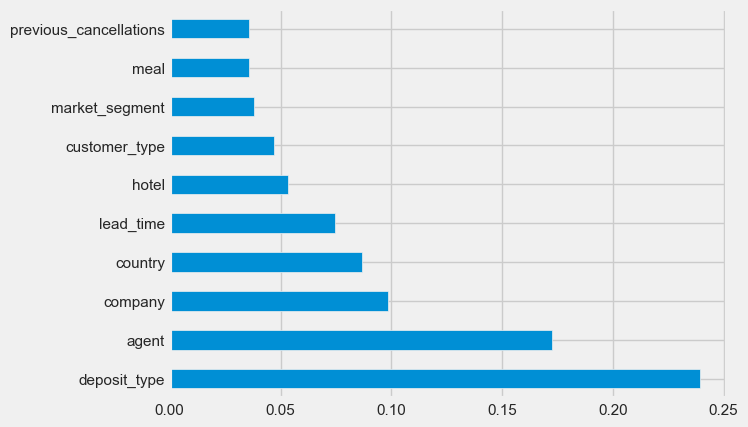

In [225]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
feat_importances = pd.Series(best_model_rf_3.feature_importances_, index = best_model_rf_3.feature_names_in_)
feat_importances.nlargest(10).plot(kind='barh');
plt.show()

In [210]:
feat_importances.values

array([0.02143372, 0.08666409, 0.03578719, 0.0242803 , 0.01639658,
       0.17244272, 0.07466562, 0.04722512, 0.02807009, 0.05358398,
       0.03824912, 0.23936313, 0.03556255, 0.02002989, 0.09836403,
       0.00788186])

In [247]:
X_unique_2 = X_unique.copy()
original_data = pd.read_csv('hotel_bookings.csv')

In [250]:
from sklearn.preprocessing import StandardScaler
s_scaler = StandardScaler()
X_unique_2['assigned_preference'] = original_data.reserved_room_type == original_data.assigned_room_type
X_unique_2['total_guests'] = original_data.adults + original_data.children.fillna(0) + original_data.babies
X_unique_2['total_guests'] = s_scaler.fit_transform(pd.DataFrame(X_unique_2['total_guests'], columns=['total_guests']))
X_unique_2['total_nights'] = original_data.stays_in_week_nights + original_data.stays_in_weekend_nights
X_unique_2['total_nights'] = s_scaler.fit_transform(pd.DataFrame(X_unique_2['total_nights'], columns=['total_nights']))
X_unique_2.head()

,reserved_room_type,country,meal,arrival_date_week_number,assigned_room_type,agent,lead_time,customer_type,adr,hotel,market_segment,deposit_type,previous_cancellations,required_car_parking_spaces,company,previous_bookings_not_canceled,assigned_preference,total_guests,total_nights
0,-0.365215,-0.196885,-0.001281,-0.012141,-1.222348,-0.382328,2.227051,0.254188,-2.015038,-0.730157,-1.251272,-0.334665,-0.10318,-0.254873,-0.314317,-0.091555,True,0.043967,-1.340370
1,0.679368,-0.421933,1.216998,-0.012141,-0.761774,-0.566222,5.923385,1.406445,-2.015038,0.054964,-0.926743,0.057439,-0.10318,-0.254873,-0.572339,-0.091555,True,0.043967,-1.340370
2,-0.856452,-0.805938,-0.989060,-0.012141,-1.595781,-1.202617,-0.907814,-0.680060,-0.530935,-1.366731,-1.514400,-0.652583,-0.10318,-0.254873,-1.465273,-0.091555,False,-1.340324,-0.949352
3,0.373935,-0.727809,0.224840,-0.012141,0.669419,-0.268401,-0.851667,0.468055,-0.530935,-0.584433,-0.985215,-0.261888,-0.10318,-0.254873,-1.307319,-0.091555,True,-1.340324,-0.949352
4,0.678844,-0.889431,0.525663,-0.012141,0.938760,-0.116836,-0.842309,0.752576,-0.075810,-0.390567,0.296956,-0.165068,-0.10318,-0.254873,-1.341643,-0.091555,True,0.043967,-0.558334


In [259]:
space_rf_4 = {
    'n_estimators': scope.int(hp.uniform('n_estimators', 100, 1000)),
    'max_depth': scope.int(hp.uniform('max_depth', 1, 30)),
    'min_samples_split': scope.int(hp.uniform('min_samples_split', 1, 20)),
    'min_samples_leaf': scope.int(hp.uniform('min_samples_leaf', 1,  20)),
    'criterion': 'gini',
    'n_jobs': -1,
    'max_features': 9
}

def objective_rf_4(params):
    clf = RandomForestClassifier(**params)
    X_train, X_test, y_train, y_test = train_test_split(X_unique_2, y, test_size=0.33)
    clf = train_rf_classifier(X_train, y_train, clf)
    preds = clf.predict(X_test)
    f1 = f1_score(np.ravel(y_test), np.ravel(preds))
    print("SCORE:", f1)
    return {'loss': -f1, 'status': STATUS_OK, 'model': clf}

In [260]:
trials_4 = Trials()
best4 = fmin(fn=objective_rf_4,
             space=space_rf_4,
             algo=tpe.suggest,
             max_evals=30,
             trials=trials_4)
print(best4)

SCORE:                                                
0.8066174481079201                                    
SCORE:                                                                           
0.8887203380647957                                                               
SCORE:                                                                           
0.8922155688622754                                                               
SCORE:                                                                           
0.7816598955310506                                                               
SCORE:                                                                           
0.6271811037606003                                                               
SCORE:                                                                           
0.9055817129712829                                                               
SCORE:                                                                

In [280]:
best_model_rf_4 = trials_4.best_trial['result']['model']

In [281]:
X_train, X_test, y_train, y_test = train_test_split(X_unique_2, y, test_size=0.33)
print(classification_report_with_scores(np.ravel(y_test), np.ravel(best_model_rf_4.predict(X_test))))


Accuracy: 0.979
False Positive Rate: 0.010
False Negative Rate: 0.039
Precision: 0.983
Recall: 0.961
RMSE:0.144
F1-Score:0.972
F2-Score:0.965
ROC_AUC_Score:0.976
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     24729
           1       0.98      0.96      0.97     14670

    accuracy                           0.98     39399
   macro avg       0.98      0.98      0.98     39399
weighted avg       0.98      0.98      0.98     39399



# Since this data was arcsinh normalized before scaling, we can use the same features on a non arcsinh normalized model then test

In [282]:
df_2 = pd.read_parquet('standard_data_2.parquet.gzip')

,hotel,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,...,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests
0,-1.407119,2.227051,-0.92889,-1.310240,0.247897,-0.260667,-0.081579,0.140979,-0.278294,-1.684238,...,-1.862628,4.260101,-0.372636,-0.560924,-0.610870,-0.131924,0.562336,-2.015038,-0.254873,-0.720694
1,-1.407119,5.923385,-0.92889,-1.310240,0.247897,-0.260667,-0.081579,0.140979,-1.217395,-1.684238,...,-1.862628,5.793131,-0.372636,-1.323956,-2.068116,-0.131924,0.562336,-2.015038,-0.254873,-0.720694
2,-1.407119,-0.907814,-0.92889,-0.786207,-1.478447,-0.260667,-0.081579,0.140979,-0.278294,-1.684238,...,-1.862628,-0.338990,-0.372636,-1.578300,-2.553864,-0.131924,0.562336,-0.530935,-0.254873,-0.720694
3,-1.407119,-0.851667,-0.92889,-0.786207,-1.478447,-0.260667,-0.081579,0.140979,-1.217395,-1.420712,...,0.760383,-0.338990,-0.372636,-0.560924,-2.796738,-0.131924,0.562336,-0.530935,-0.254873,-0.720694
4,-1.407119,-0.842309,-0.92889,-0.262174,0.247897,-0.260667,-0.081579,0.140979,-1.530429,-0.024826,...,0.760383,-0.338990,-0.372636,-0.560924,-2.942463,-0.131924,0.562336,-0.075810,-0.254873,0.540666


In [291]:
new_vals = ['assigned_preference', 'total_guests', 'total_nights', 'arrival_date_week_number' ]
feature_list_2 = [col for col in X_unique_2.columns if col not in new_vals]

In [293]:
df_2 = df_2[feature_list_2]
df_2[new_vals] = X_unique_2[new_vals].copy()

In [295]:
import copy
best_model_rf_5 = copy.deepcopy(best_model_rf_4)

In [296]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(df_2, y, test_size=0.33)

In [298]:
best_model_rf_5.fit(X_train2, y_train2)

RandomForestClassifier(max_depth=29, max_features=9, n_estimators=997,
                       n_jobs=-1)

In [299]:
print(classification_report_with_scores(np.ravel(y_test), np.ravel(best_model_rf_5.predict(X_test2))))


Accuracy: 0.532
False Positive Rate: 0.373
False Negative Rate: 0.630
Precision: 0.371
Recall: 0.370
RMSE:0.684
F1-Score:0.371
F2-Score:0.371
ROC_AUC_Score:0.499
              precision    recall  f1-score   support

           0       0.63      0.63      0.63     24729
           1       0.37      0.37      0.37     14670

    accuracy                           0.53     39399
   macro avg       0.50      0.50      0.50     39399
weighted avg       0.53      0.53      0.53     39399



# Import the prescaled data as is, scale the training data, then apply the fitted scaler on testing data

In [343]:
X_unscaled = pd.read_parquet('data_imputed.gzip.parquet')
X_unscaled['total_guests'] = X_unscaled.adults + X_unscaled.children + X_unscaled.babies
X_unscaled['total_nights'] = X_unscaled.stays_in_week_nights + X_unscaled.stays_in_weekend_nights
X_unscaled['arrival_date_week_number'] = original_data.arrival_date_week_number.copy()

In [344]:
col_list_new = [col for col in X_unique_2.columns if col not in ['assigned_preference']]
X_unscaled = X_unscaled[col_list_new]

In [345]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(X_unscaled, y, test_size=0.33)
X_train3.shape, X_test3.shape

((79991, 18), (39399, 18))

In [346]:
scaler_new = StandardScaler()
X_train3 = pd.DataFrame(scaler_new.fit_transform(X_train3), columns=X_train3.columns)
X_test3 = pd.DataFrame(scaler_new.transform(X_test3), columns=X_test3.columns)

In [347]:
X_train3['assigned_preference'] = X_unique_2.assigned_preference.iloc[X_train3.index]
X_test3['assigned_preference'] = X_unique_2.assigned_preference.iloc[X_test3.index]

In [367]:
space_rf_6 = {
    'n_estimators': scope.int(hp.uniform('n_estimators', 100, 1000)),
    'max_depth': scope.int(hp.uniform('max_depth', 1, 30)),
    'min_samples_split': scope.int(hp.uniform('min_samples_split', 1, 20)),
    'min_samples_leaf': scope.int(hp.uniform('min_samples_leaf', 1,  20)),
    'criterion': 'gini',
    'n_jobs': -1,
    'max_features': 9
}

def objective_rf_6(params):
    clf = RandomForestClassifier(**params, n_jobs=-1)
    clf.fit(X_train3.drop(['agent', 'company', 'country'], axis=1), y_train3)
    preds = clf.predict(X_test3.drop(['agent', 'company', 'country'], axis=1))
    f1 = f1_score(np.ravel(y_test3), np.ravel(preds))
    print("SCORE:", f1)
    return {'loss': -f1, 'status': STATUS_OK, 'model': clf}

In [369]:
trials_6 = Trials()
best6 = fmin(fn=objective_rf_6,
             space=space_rf_6,
             algo=tpe.suggest,
             max_evals=3,
             trials=trials_6)
print(best6)

SCORE:                                               
0.7280607548327709                                   
SCORE:                                                                           
0.6490351481736732                                                               
SCORE:                                                                           
0.6596929306563185                                                               
100%|██████████| 3/3 [08:27<00:00, 169.21s/trial, best loss: -0.7280607548327709]
{'max_depth': 25.974751416904343, 'min_samples_leaf': 15.758921899295041, 'min_samples_split': 14.805276934988253, 'n_estimators': 523.5701520060618}
  0%|          | 0/3 [03:17<?, ?trial/s, best loss=?]


KeyboardInterrupt: 

In [363]:
best_model_rf_6 = trials_6.best_trial['result']['model']

In [364]:
best_model_6 = trials_6.results[np.argmin([r['loss'] for r in
                                       trials_6.results])]['model']

In [366]:
best_model_6.feature_names_in_

array(['reserved_room_type', 'country', 'meal',
       'arrival_date_week_number', 'assigned_room_type', 'agent',
       'lead_time', 'customer_type', 'adr', 'hotel', 'market_segment',
       'deposit_type', 'previous_cancellations',
       'required_car_parking_spaces', 'company',
       'previous_bookings_not_canceled', 'assigned_preference',
       'total_guests', 'total_nights'], dtype=object)

In [ ]:
print(classification_report_with_scores(np.ravel(y_test3), np.ravel(best_model_rf_6.predict(X_test3.drop(['company', 'agent', 'country'], axis=1)))))

ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- agent
- company
- country


In [330]:
best_model_rf_6.fit(X_train3, y_train3)

RandomForestClassifier(max_depth=29, max_features=9, min_samples_split=1,
                       n_estimators=404, n_jobs=-1)

In [332]:
X_train3

,reserved_room_type,country,meal,arrival_date_week_number,assigned_room_type,agent,lead_time,customer_type,adr,hotel,market_segment,deposit_type,previous_cancellations,required_car_parking_spaces,company,previous_bookings_not_canceled,total_guests,total_nights,assigned_preference
0,0.580358,-0.198084,0.083504,-0.965250,0.761469,1.129150,-0.220961,-1.762725,-0.573363,0.711553,-0.021628,-0.371836,-0.103825,-0.256208,0.647385,-0.089041,-1.367952,0.225448,True
1,0.580358,0.995116,0.141723,-0.083707,0.761469,-1.652663,-0.792738,-1.762725,0.157075,0.711553,-1.418959,-0.371836,-0.103825,-0.256208,0.408521,-0.089041,0.042869,-0.559604,True
2,-1.108876,-1.443062,0.141723,0.357064,-1.854965,-1.322403,0.810113,0.562348,1.859818,-1.405428,-1.682758,-0.371836,-0.103825,-0.256208,-1.196942,-0.089041,2.864510,1.403026,False
3,0.580358,-0.513095,0.141723,-0.083707,0.761469,-0.280345,-0.942713,0.562348,0.408617,0.711553,-1.682758,-0.371836,-0.103825,-0.256208,0.410990,-0.089041,0.042869,-0.559604,True
4,0.580032,0.950377,0.141280,-0.744864,0.761331,-0.882489,-0.820859,0.562179,0.479242,0.711362,-1.683374,-0.371877,-0.103825,-0.256208,0.392086,-0.089041,0.042869,0.617974,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79986,0.580032,0.409249,-1.056223,-0.157169,0.761331,-0.653457,1.269409,0.562179,0.199644,0.711362,-0.208767,2.686298,-0.103825,-0.256208,-0.653553,-0.089041,0.042869,-0.559604,True
79987,-1.475219,-0.464213,0.141280,-0.524479,-1.210217,1.428080,0.107108,0.562179,0.640809,0.711362,-0.021765,-0.371877,-0.103825,-0.256208,0.477273,-0.089041,0.042869,-0.167078,True
79988,0.580358,-0.312351,0.141723,0.944759,0.761469,1.306109,-0.923966,-1.762725,1.318036,0.711553,1.869857,-0.371836,-0.103825,-0.256208,0.867158,-0.089041,0.042869,-0.952130,True
79989,-1.473759,0.235222,0.141723,-1.259098,-1.209815,1.244076,-0.689631,-1.762725,0.278976,0.711553,-0.021628,-0.371836,-0.103825,-0.256208,0.716520,-0.089041,0.042869,-0.559604,True


In [331]:
print(classification_report_with_scores(np.ravel(y_test3), np.ravel(best_model_rf_6.predict(X_test3))))


Accuracy: 1.000
False Positive Rate: 0.000
False Negative Rate: 0.000
Precision: 1.000
Recall: 1.000
RMSE:0.000
F1-Score:1.000
F2-Score:1.000
ROC_AUC_Score:1.000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     24700
           1       1.00      1.00      1.00     14699

    accuracy                           1.00     39399
   macro avg       1.00      1.00      1.00     39399
weighted avg       1.00      1.00      1.00     39399



In [333]:
best_model_rf_6.feature_importances_

array([1.15271690e-01, 1.79042711e-03, 2.22230945e-01, 3.96316825e-05,
       4.02197273e-02, 2.60820429e-03, 4.13217864e-05, 1.30407471e-01,
       5.72757856e-05, 3.31893139e-02, 9.26151280e-03, 4.43206975e-01,
       1.14760886e-03, 3.36981419e-04, 4.18113878e-05, 6.95781701e-06,
       1.15103612e-04, 2.64304279e-05, 6.11893991e-07])

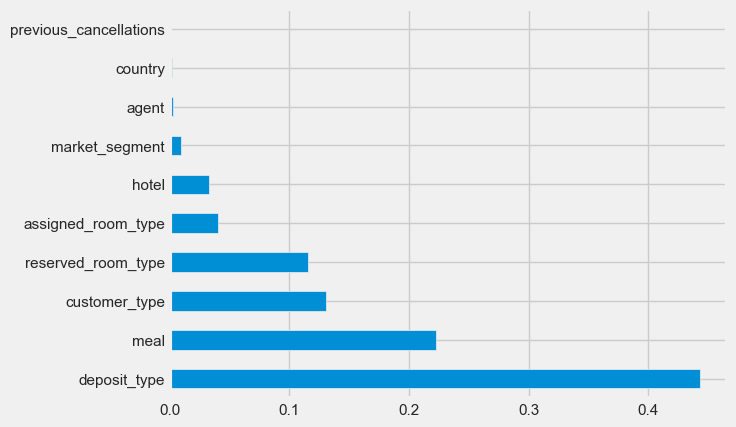

In [334]:
feat_importances2 = pd.Series(best_model_rf_6.feature_importances_, index = best_model_rf_6.feature_names_in_)
feat_importances2.nlargest(10).plot(kind='barh');
plt.show()

### Base random forest with 9 max features and 200 estimators as a pseudo baseline model

In [354]:
clf = RandomForestClassifier(verbose=True, n_jobs=-1, criterion='gini', max_features=9, n_estimators=200)
X_train, X_test, y_train, y_test = train_test_split(X_unscaled.drop(['agent', 'company', 'country'], axis=1), y, test_size=0.33)
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
f1 = f1_score(np.ravel(y_test), np.ravel(preds))
print("SCORE:", f1)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   25.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    2.4s


SCORE: 0.7706619733486585


[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    2.8s finished


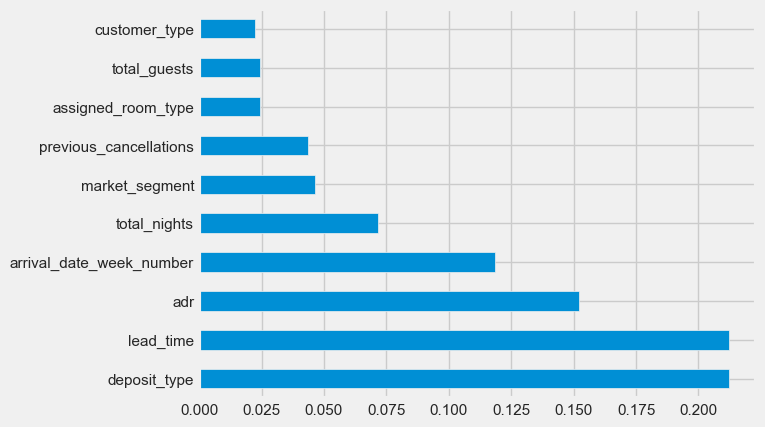

In [355]:
feat_importances3 = pd.Series(clf.feature_importances_, index = clf.feature_names_in_)
feat_importances3.nlargest(10).plot(kind='barh');
plt.show()

In [ ]:
print(classification_report_with_scores(y_test, preds))

In [ ]:
clf.get_params()

In [166]:
print(classification_report_with_scores(np.ravel(y_test), np.ravel(preds)))


Accuracy: 0.919
False Positive Rate: 0.029
False Negative Rate: 0.172
Precision: 0.942
Recall: 0.828
RMSE:0.285
F1-Score:0.882
F2-Score:0.849
ROC_AUC_Score:0.900
              precision    recall  f1-score   support

           0       0.91      0.97      0.94     24992
           1       0.94      0.83      0.88     14407

    accuracy                           0.92     39399
   macro avg       0.92      0.90      0.91     39399
weighted avg       0.92      0.92      0.92     39399



In [159]:
print("SCORE:", f1)

SCORE: 0.9111952561263128


In [373]:
data_final_encoding = pd.read_parquet('data_imputed_2.gzip.parquet')
X_train_final, X_test_final, y_tr, y_te = train_test_split(data_final_encoding, y, test_size=0.33)

In [376]:
rfc_final = RandomForestClassifier(n_jobs=-1)
rfc_final.fit(X_train_final, y_tr)

RandomForestClassifier(n_jobs=-1)

In [377]:
print(classification_report_with_scores(y_te, rfc_final.predict(X_test_final)))


Accuracy: 0.886
False Positive Rate: 0.072
False Negative Rate: 0.186
Precision: 0.870
Recall: 0.814
RMSE:0.337
F1-Score:0.841
F2-Score:0.825
ROC_AUC_Score:0.871
              precision    recall  f1-score   support

           0       0.89      0.93      0.91     24808
           1       0.87      0.81      0.84     14591

    accuracy                           0.89     39399
   macro avg       0.88      0.87      0.88     39399
weighted avg       0.89      0.89      0.89     39399



<Axes: >

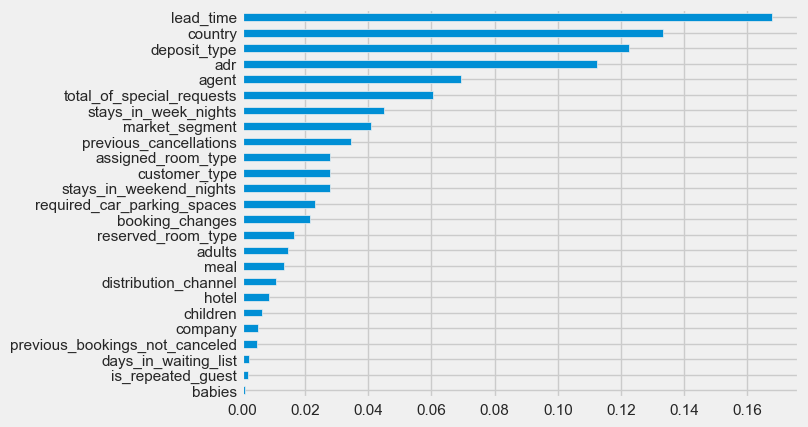

In [380]:
pd.Series(rfc_final.feature_importances_, index=rfc_final.feature_names_in_).\
    sort_values().plot(kind='barh')